In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Вычисление элементарных функций

Вычисление значения функции на данном аргументе является одной из важнейших задач численных методов.
Несмотря на то, что вы уже огромное число раз вычисляли значения функций на практике, вам вряд ли приходилось самостоятельно реализовывать вычисление функций, не сводящихся к композиции элементарных.
Действительно, калькуляторы, стандартные библиотеки, математические пакеты и т.п. позволяют вам легко и зачастую с произвольной точностью вычислять значение широко известных функций.
Однако иногда вычисление элементраных функций приходится реализовывать самостоятельно, например, если вы пытаетесь добиться более высокой производительности, улучшить точность, эффективно распараллелить вычисления, используете среду/оборудование, для которого нет математических библиотек и т.п.
Алгоритмы вычисления элементарных функций сами по себе поучительны, так как учат нас избегать типичных ошибок расчетов на компьютере, подсказывают, как реализовать вычисления неэлементарных функций, а также позволяют рассмотреть нам некоторые методы, которые полностью проявляют свою мощь в более сложных задачах.

В этой лабораторной работе мы рассмотрим задачу вычисления натурального логарифма $y=\ln x$.
Функция выбрана достаточно произвольно, подобных оразом можно вычислить и другие элементарные функции.
Сразу стоит обратить внимание, что используемые методы достаточно универсальны, но не являются самыми быстрыми.

## Элементарные свойства. Редукция аргумента.

По-определению, натуральным логарифмом называется функция, обратная к экспоненте, т.е. $y=\ln x$ тогда и только тогда, когда $x=e^y$.
Поэтому если мы можем вычислять показательную функцию, то легко построить график логарифмической функции, нужно просто поменять переменные местами.

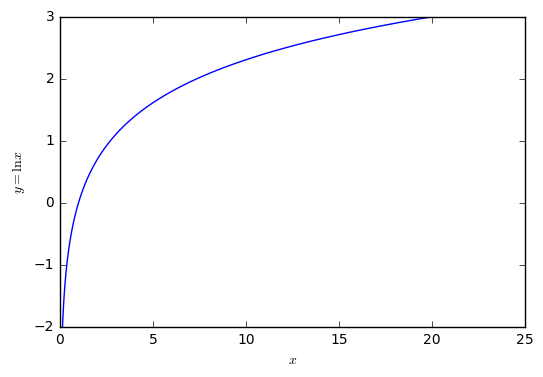

In [2]:
y=np.linspace(-2,3,100)
x=np.exp(y)
plt.plot(x,y)
plt.xlabel('$x$')
plt.ylabel('$y=\ln x$')
plt.show()

Для графического представления данных часто используется логарифмическая шкала, на которой находищиеся на одном расстоянии точки отличаются в одно и то же число раз.
График логарифма в логарифмической шкале по аргументу $x$ выглядит как прямая линия.

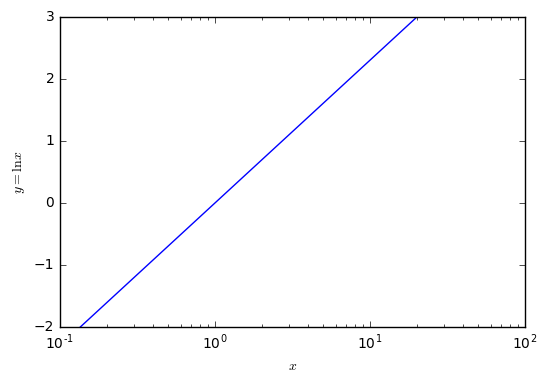

In [3]:
plt.semilogx(x,y)
plt.xlabel('$x$')
plt.ylabel('$y=\ln x$')
plt.show()

Лоагрифм преобразует умножение в сложение:
$$\ln (xy)=\ln x+\ln y.$$
а возведение в степень в умножение
$$\ln x^a=a\ln x.$$
Это свойство, например, может быть использовано для вычисления произвольных вещественных степеней:
$$a^x=\exp(\ln a^x)=\exp(a\ln x).$$
Это свойство можно применить и для того, чтобы выразить значения логарифма в одних точках, через значения в других, избежав вычислений значений в неудобных точках.
Например, воспользовавшись свойством
$$\ln \frac1x=-\ln x,$$
можно вычислять значения логарифма на всей области определения, реализовав вычисление логарифма только на интервале $(0,1]$ или от $[1,\infty)$.
Этот подход называется *редукцией* аргумента, и ипользуется при вычислении почти всех функций.

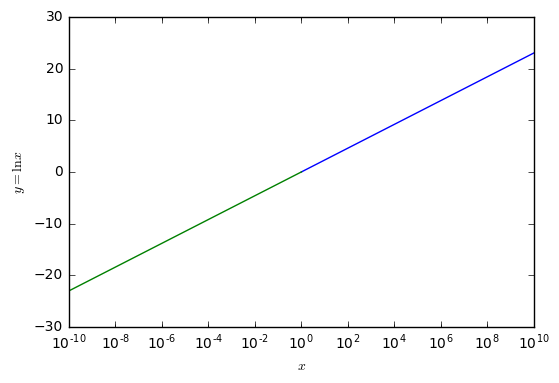

In [4]:
x=np.logspace(0,10,100)
y=np.log(x)
plt.semilogx(x,y)
plt.semilogx(1/x,-y)
plt.xlabel('$x$')
plt.ylabel('$y=\ln x$')
plt.show()

**Задание 1.** Выполните редукцию аргумента логарифма так, чтобы всегда получать значения из интервала $[1,1+\epsilon)$, где $\epsilon$ - маленькое положительное число. Каким свойством предпочтительнее воспользоваться $\ln x^2=2\ln x$ или $\ln \frac{x}{2}=\ln x-\ln 2$? 

Результат даже точного вычислении логарифма имеет погрешность равную произведению погрешности аргумента на число обусловленности.
Число обусловленности можно найти по формуле:
$$\kappa(x)=\frac{|x(\ln x)'|}{|ln x|}=\frac{|x/x|}{|\ln x|}=\frac{1}{|\ln x|}.$$
Так как погрешность аргумента всегда не привосходит, но может достигать половины машинной точности, то лучшая реализация вычисления логарфима будет иметь следующую точность:

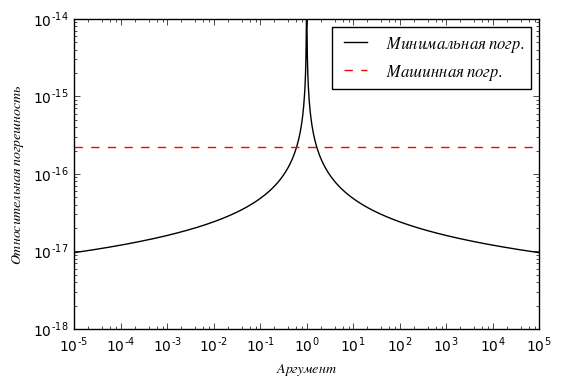

In [5]:
x0=np.logspace(-5,5,1000,dtype=np.double)
epsilon=np.finfo(np.double).eps
best_precision=(epsilon/2)*np.abs(1./np.log(x0))
plt.loglog(x0,best_precision, '-k')
plt.loglog(x0,np.full(x0.shape, epsilon), '--r')
plt.xlabel("$Аргумент$")
plt.ylabel("$Относительная\,погрешность$")
plt.legend(["$Минимальная\,погр.$","$Машинная\,погр.$"])
plt.show()

Формально при $x=1$ число обусловленности равно бесконечности (так как значение функции равно $0$), однако этот пик очень узкий, так что почти всюду значения могут быть найдены с машинной точностью, кроме узкого 

## Разложение в степенной ряд

Из математического анализа нам известно, что для $|x|<1$ справедливо разложение логарифма в ряд:
$$\ln (1+x)=\sum_{k=1}^\infty (-1)^{n+1}x^k/k=x-x^2/2+x^3/3+\ldots.$$
Так как правая часть содержит только арифметические операции, то возникает соблазн использовать частичную сумму этого ряда для приближенного вычисления логарифма.
Первое препятствие на этом пути - это сходимость ряда только на малом интервале, т.е. таким способом могут быть получены только значения $\ln x$ для $x\in(0,2)$.
Вторая сложность заключается в том, что частичная сумма $S_N$ из $N$ членов ряда
$$S_N=\sum_{k=1}^N (-1)^{n+1}{x^k}/k$$
дает только часть суммы, а остаток ряда
$$R_N=\sum_{k=N+1}^\infty (-1)^{n+1}{x^k}/k$$
быстро увеличивается, если значения $x$ увеличиваются по модулю.
Вычислим численно относительную погрешность отбрасывания остатка ряда.

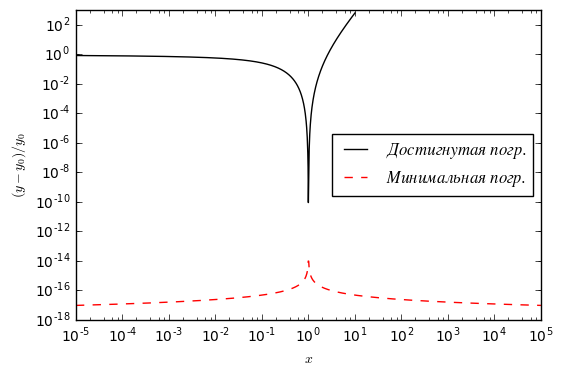

In [6]:
def relative_error(x0,x): return np.abs(x0-x)/np.abs(x0)

def log_teylor_series(x, N=5):
    a=x-1
    a_k=a # x в степени k. Сначала k=1
    y=a # Значене логарифма, пока для k=1.
    for k in range(2,N): # сумма по степеням
        a_k=-a_k*a # последовательно увеличиваем степень и учитываем множитель со знаком
        y=y+a_k/k
    return y

x=np.logspace(-5,1,1001)
y0=np.log(x)
y=log_teylor_series(x)
plt.loglog(x,relative_error(y0,y),'-k')
plt.loglog(x0,best_precision,'--r')
plt.xlabel('$x$')
plt.ylabel('$(y-y_0)/y_0$')
plt.legend(["$Достигнутая\;погр.$", "$Минимальная\;погр.$"],loc=5)
plt.show()
    

Формула Эйлера дает аккуратное приближение функции только рядом с точкой разложения (в даном случае $x=1$), что мы и наблюдаем в эксперименте. 
Наибольшую точность мы получили возле $x=1$, что противоречит нашей оценке через числа обусловленности. 
Однако нужно принимать во внимание, что мы сравнивали нашу реализацию со встроенной, которая не дает (и не может дать) абсолютно правильный ответ.

Точность вычислений можно увеличить, добавляя слагаемые в частичную сумму.
Сколько слагаемых нужно взять, чтобы достигнуть желаемой точности?
Распространено заблуждение, что суммировать нужно до тех пор, пока последнее добавленное слагаемое не станет меньше желаемой точности.
Вообще говоря это не так. 
Чтобы получить верную оценку погрешности отбрасывания остатка ряда, нужно оценить весь остаток ряда, а не только последнее слагаемое.
Для оценки остатка ряда можно воспользоваться формулой Лагранжа для остаточного члена:
$$R_N=\frac{a^{N+1}}{(N+1)!}\frac{d^{N+1}f(a\theta)}{da^{N+1}},$$
где как и выше $a=x-1$, а $\theta$ лежит на интервале $[0,1]$.

**Задание 2.** Найдите количество слагаемых в частичной сумме, достаточное для получения значения логарифма с заданной точностью. Реализуйте вычисления логарифма через сумму с заданной точностью. Какую максимальную точность удается достичь?

## Аппроксимация многочленами

При вычислении логарифма через частичную суммы мы по сути приближали логарифм многочленами.
Многочлен Тейлора давал хорошее приближение функции и нескольких производных, но только в одной точке.
Мы же сейчас интересуемся только значением функции, но хотели бы иметь хорошую точность приближения на целом интервале.
Для достижения этой цели многочлены Тейлора подходят плохо, однако можно воспользоваться многочленами Лагранжа, Чебышева и т.п., или можно попытаться минимизировать непосредственно ошибку прилижения на отрезке, варьируя коэффициенты многочлена.

В качестве примера мы рассмотрим построение интерполяционного многочлена Лагранжа.
Этот многочлен будет точно совпадать с приближаемой функцией в $N+1$ узле, где $N$~-- степень многочлена, а между узлами мы надеямся, что погрешность не будет слишком силько расти. Зафиксируем несколько значений $x_n=1+1/(n+1)$, $n=0..N$, из интервала $[1,2]$ и вычислим в них точные значения логарифма в этих точках $y_n=\ln(x_n)$. Тогда интерполяционный многочлен имеет вид:
$$L(x)=\sum_{n=0}^{N}\prod_{k\neq n} \frac{x-x_k}{x_n-x}.$$

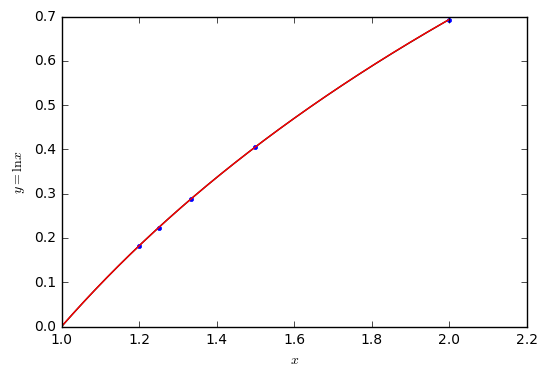

In [7]:
# Узлы итерполяции
N=5
xn=1+1./(1+np.arange(N))
yn=np.log(xn)
# Тестовые точки
x=np.linspace(1+1e-10,2,1000)
y=np.log(x)
# Многочлен лагранжа
import scipy.interpolate
L=scipy.interpolate.lagrange(xn,yn)
yl=L(x)
plt.plot(x,y,'-k')
plt.plot(xn,yn,'.b')
plt.plot(x,yl,'-r')
plt.xlabel("$x$")
plt.ylabel("$y=\ln x$")
plt.show()

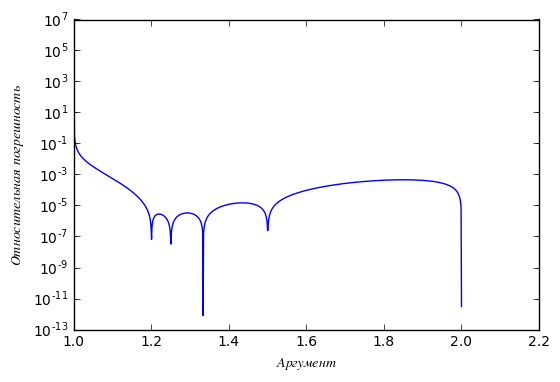

In [8]:
plt.semilogy(x,relative_error(y,yl))
plt.xlabel("$Аргумент$")
plt.ylabel("$Относительная\;погрешность$")
plt.show()

Как мы видим, погрешность стремится к нулю в узлах интерполяции, между узлами ошибка не растет выше некоторой величины, т.е. с точки зрения вычисления функции этот приближение гораздо лучше.

**Задание 3.** Как следует из графика ошибки, предложенный выбор узлов $x_n$ плох. 
Подумайте, как лучше расположить узлы интерполяции? 
Воспользуйтесь формулой приведения 
$$x=\frac{1+2u/3}{1-2u/3},$$
позволяющей преобразовать интервал $x\in[1/5,5]$ в интервал $u\in[-1,1]$.
Будет ли разложение по степеням $u$ предпочтительнее разложения по степеням $a=x-1$?
Составьте интерполяционный многочлен Лагранжа от переменной $u$ с узлами в нулях многочлена Чебышева:
$$u_n=\cos\frac{\pi(n+1/2)}{N+1},\quad n=0..N.$$
Сравните точности аппроксимации с узлами в $x_n$ и в $u_n$.

**Задание A (повышенная сложность).** Найдите многочлен данной степени $N$, дающий наименьшую погрешность приближения логарифма на интервале $[1/5,5]$.

**Задание B (повышенная сложность).** Постройте разложение логарифма на интервале $[1/5,5]$ по многочленам Чебышева от переменной $u$ методом Ланцоша.

## Итерационный метод

Для нахождения $y$, такого что $y=\ln x$, можно численно решить уравнение $x=e^y$,
что может оказаться проще, чем считать логарифм напрямую.
Для решения уравнения воспользуемся методом Ньютона.
Перепишем уравнение в виде $F(y)=e^y-x=0$, т.е. будем искать нули функции $F$.
Пусть у нас есть начальное приближение для $y=y_0$.
Приблизим функцию $F$ рядом с $y_0$ с помощью касательной,
т.е. $F(y)\approx F'(y_0)(y-y_0)+F(y_0)$.
Если функция $F$ близка к линейной (что верно, если $y_0$ близко к нулю функции), то точки пересечения функции и касательной с осью абсцисс близки.
Составим уравнение на ноль касательной:
$$F'(y_0)(y-y_0)+F(y_0)=0,$$
следовательно следующим приближением  выберем
$$y=y_0-\frac{F(y_0)}{F'(y_0)}.$$
Итерации по методу Ньютона определены следующей рекуррентной формулой:
$$y_{n+1}=y_n-\frac{F(y_n)}{F'(y_n)}.$$
Подставляя явный вид функции $F$, получаем
$$y_{n+1}=y_n-\frac{e^{y_n}-x}{e^{y_n}}=y_n-1+xe^{-y_n}.$$
Точное значение логарифма есть предел последовательности $y_n$ при $n\to\infty$.
Приближенное значение логарифма можно получить сделав несколько итераций.
При выполнении ряда условий метод Ньютона имеет квадратичную скорость сходимости, т.е.
$$|y_n-y^*|<\alpha|y_{n-1}-y^*|^2,$$
где $y^*=\lim_{n\to\infty} y_n$ - точное значение логарифма, и $\alpha\in(0,1]$ - некоторая константа.
Неформально выражаясь, квадратичная сходимость означает удвоение числа значащих цифр на каждой итерации. 

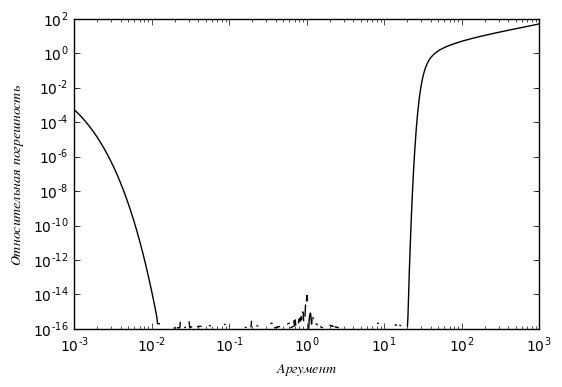

In [9]:
def log_newton(x, N=10):
    y=1 # начальное приближение
    for j in range(N):
        y=y-1+x/np.exp(y)
    return y

x=np.logspace(-3,3,1000)
y0=np.log(x)
y=log_newton(x)
plt.loglog(x,relative_error(y0,y),'-k')
plt.xlabel("$Аргумент$")
plt.ylabel("$Относительная\;погрешность$")
plt.show()

**Задание 4.** Начальное приближение в вышеприведенном алгоритме выбрано очень грубо, предложите лучшее приближение. Оцените число итераций, необходимое для получения лучшей возможной точности. Реализуйте метод Ньютона для найденного числа итераций. Удалось ли получить машиную точность? Почему? Почему при использовании 1 в качестве начального приближения итерации расходятся для $x$ заметно отличающихся от 1?

## Вычисление с помощью таблиц

Число с плавающей запятой представляется в виде $M\cdot 2^E$, где $M$ - мантисса, а $E$ - экспонента.
Согласно основному свойству логарифма
$$\ln (M\cdot 2^E)=E\ln 2+\ln M,$$
где константу $\ln 2$ можно предварительно вычислить и сохранить, экспонента представляет собой данное нам целое число, единственно что нам остается вычислить - это логарифм мантиссы.
Так как мантисса всегда лежит в интервале $(-1,1)$, а с учетом области определения логарима, в интервале $(0,1)$, то мы можем приближенно найти значение $\ln M$ как сохраненное в таблице значение логарифма в ближайшей к $M$ точке. 
Для составления таблицы удобно отбросить все биты мантиссы, кроме нескольких старших,
перебрать все их возможные значения и вычислить логарифм этих значений.

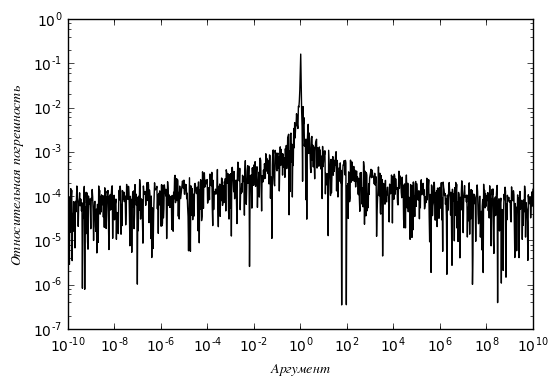

In [10]:
B=8 # число используемых для составления таблицы бит мантиссы
table=np.log((np.arange(0,2**B, dtype=np.double)+0.5)/(2**B))
log2=np.log(2)

def log_table(x):
    M,E=np.frexp(x)
    return log2*E+table[(M*2**B).astype(np.int)]

x=np.logspace(-10,10,1000)
y0=np.log(x)
y=log_table(x)
plt.loglog(x,relative_error(y0,y),'-k')
plt.xlabel("$Аргумент$")
plt.ylabel("$Относительная\;погрешность$")
plt.show()

**Задание 5.** Реализуйте метод, комбинирующий таблицы и интерполяцию многочленом (достаточно первой степени). Как зависит скорость метода от степени многочлена? Как зависит точность?

**Задание 6.** Используя любой метод, реализуйте вычисление логарифма с точностью, не более чем на порядок худшей, чем теоретически возможная.